In [24]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
#from model import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt

In [25]:
start_time = time.time()
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))

In [26]:
"""
Сетевые архитектуры
Ниже приведены архитектуры дискриминатора и генератора
"""
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [27]:
# Discriminator Loss => BCELoss
def d_loss_function(inputs, targets):
    return nn.BCELoss()(inputs, targets)


def g_loss_function(inputs):
    targets = torch.ones([inputs.shape[0], 1])
    targets = targets.to(device)
    return nn.BCELoss()(inputs, targets)

In [28]:
"""
Определяем, доступны ли какие-либо графические процессоры
"""
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

# Model
G = generator().to(device)
D = discriminator().to(device)
print(G)
print(D)

# Settings
epochs = 30
lr = 0.0002
batch_size = 64
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_set = datasets.MNIST('mnist/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

GPU State: cpu
generator(
  (fc1): Linear(in_features=128, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=784, bias=True)
  (activation): ReLU()
)
discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.1)
)


In [29]:
"""
Процедура обучения сети.
Каждый шаг потери обновляется как для дискиминатора, так и для генератора.
Дискриминатор стремится классифицировать реальные и fakes
Генератор стремится генерировать как можно более реалистичные изображения
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1
        # Обучаем дискриминатор
        # real_inputs - изображения из набора данных MNIST
        # fake_inputs - изображения от генератора
        # real_inputs должны быть классифицированы как 1, а fake_inputs - как 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)
        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        d_loss = d_loss_function(outputs, targets)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        # Обучаем генератор
        # Цель генератора получить от дискриминатора 1 по всем изображениям
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        g_loss = g_loss_function(fake_outputs)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, d_loss.item(), g_loss.item()))
    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0 Iteration 100: discriminator_loss 0.665 generator_loss 0.946
Epoch 0 Iteration 200: discriminator_loss 0.650 generator_loss 0.780
Epoch 0 Iteration 300: discriminator_loss 0.612 generator_loss 0.837
Epoch 0 Iteration 400: discriminator_loss 0.611 generator_loss 0.812
Epoch 0 Iteration 500: discriminator_loss 0.554 generator_loss 0.892
Epoch 0 Iteration 600: discriminator_loss 0.477 generator_loss 0.949
Epoch 0 Iteration 700: discriminator_loss 0.460 generator_loss 1.012
Epoch 0 Iteration 800: discriminator_loss 0.584 generator_loss 0.963
Epoch 0 Iteration 900: discriminator_loss 0.432 generator_loss 1.080
Epoch 0 Iteration 938: discriminator_loss 0.530 generator_loss 0.832
Epoch 1 Iteration 100: discriminator_loss 0.419 generator_loss 1.268
Epoch 1 Iteration 200: discriminator_loss 0.433 generator_loss 1.313
Epoch 1 Iteration 300: discriminator_loss 0.387 generator_loss 1.450
Epoch 1 Iteration 400: discriminator_loss 0.425 generator_loss 1.273
Epoch 1 Iteration 500: discriminat

GPU State: cpu


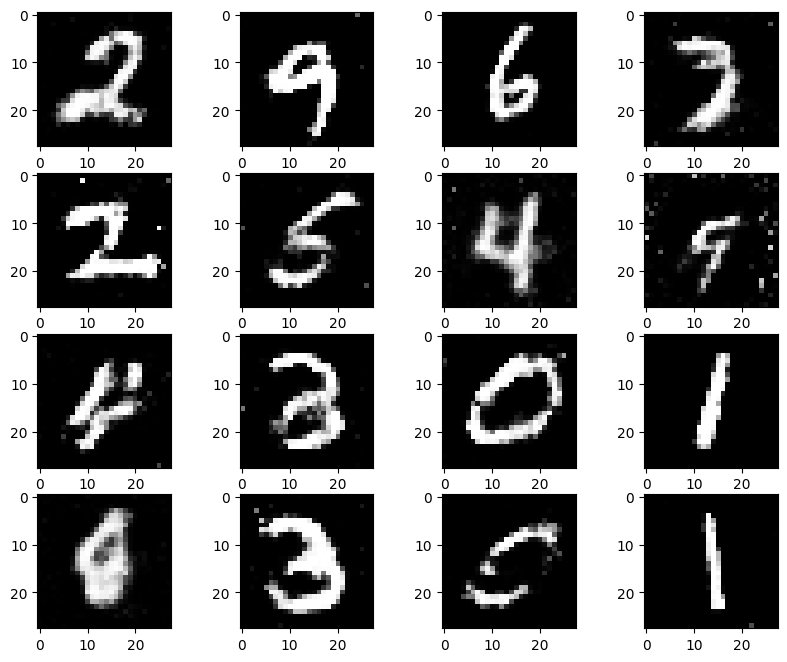

In [34]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

# Model
G = torch.load('Generator_epoch_29.pth')
G.eval()

# Generator
noise = (torch.rand(16, 128)-0.5) / 0.5
noise = noise.to(device)

fake_image = G(noise)
imgs_numpy = (fake_image.data.cpu().numpy()+1.0)/2.0
show_images(imgs_numpy)
plt.show()